In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

In [2]:
# Read the CSV file into a DataFrame
df = pd.read_csv('loan.csv')

/tmp/ipykernel_677244/1779759102.py:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('loan.csv')


In [3]:
# Remove 'months' from `term` and convert to numeric
df['term'] = df['term'].astype(str).str.replace(r'\D', '', regex=True).astype(int)

In [4]:
# Remove '%' from `int_rate` and convert to numeric
df['int_rate'] = df['int_rate'].astype(str).str.replace('%', '', regex=True).astype(float)

In [5]:
# Extract numeric values from `emp_length`, treating '10+ years' as 10
df['emp_length'] = df['emp_length'].astype(str).str.replace(r'\D', '', regex=True)
df['emp_length'] = df['emp_length'].str.replace('10', '10', regex=False)
df['emp_length'] = pd.to_numeric(df['emp_length'], errors='coerce')


In [6]:
# Remove '%' from `revol_util` and convert to numeric
df['revol_util'] = df['revol_util'].astype(str).str.replace('%', '', regex=True).astype(float)


In [7]:
# Filter for 'Fully Paid' and 'Charged Off' loans
df_filtered = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])].copy()


In [8]:
# Impute missing values with 0
columns_to_impute = ['emp_length', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc']
df_filtered[columns_to_impute] = df_filtered[columns_to_impute].fillna(0)


In [9]:
# Convert `emp_length` to numeric
df_filtered['emp_length'] = pd.to_numeric(df_filtered['emp_length'], errors='coerce')


In [10]:
# Select the specified columns
df_filtered = df_filtered[['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'emp_length', 'annual_inc', 'loan_status', 'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc']]


In [11]:
# Calculate and print summary statistics
summary_stats = df_filtered[['loan_amnt', 'int_rate', 'emp_length', 'annual_inc']].describe().loc[['mean', '50%', 'std', 'min', 'max']]
print("Summary Statistics:")
print(summary_stats.to_markdown(numalign="left", stralign="left"))

Summary Statistics:
|      | loan_amnt   | int_rate   | emp_length   | annual_inc   |
|:-----|:------------|:-----------|:-------------|:-------------|
| mean | 11047       | 11.9322    | 4.92553      | 68778        |
| 50%  | 9600        | 11.71      | 4            | 58868        |
| std  | 7348.44     | 3.69133    | 3.45392      | 64218.7      |
| min  | 500         | 5.42       | 0            | 4000         |
| max  | 35000       | 24.4       | 10           | 6e+06        |


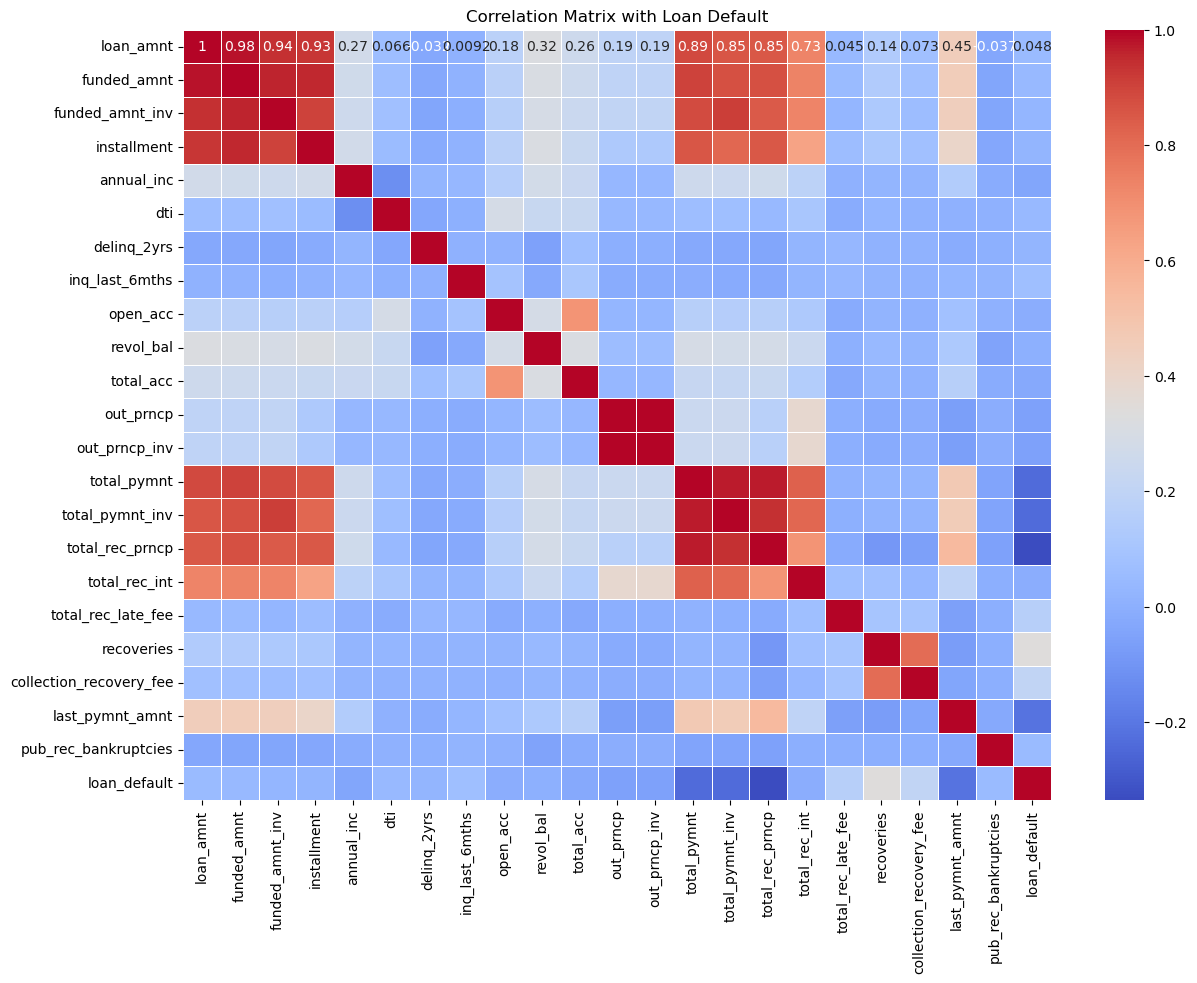

In [12]:
df_filtered['loan_default'] = df_filtered['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)
df['loan_default'] = df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)

# Select relevant numerical features along with loan_default
numerical_features = [
    'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'annual_inc',
    'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'revol_bal', 'total_acc',
    'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
    'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
    'last_pymnt_amnt', 'pub_rec_bankruptcies', 'loan_default'
]

# Compute the correlation matrix
correlation_matrix = df[numerical_features].corr()

# Plot the correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix with Loan Default')
plt.show()

/home/alpesh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


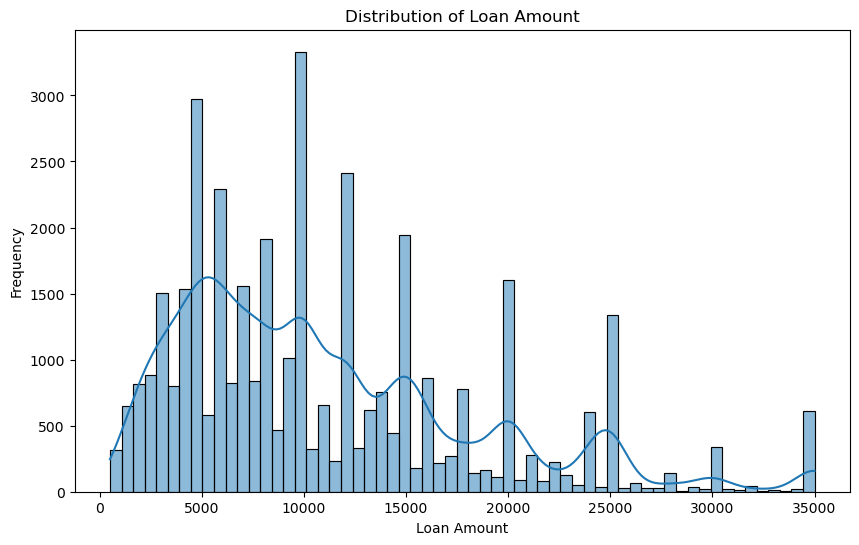

In [13]:
# Univariate Analysis
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['loan_amnt'], kde=True)
plt.title('Distribution of Loan Amount')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.show()

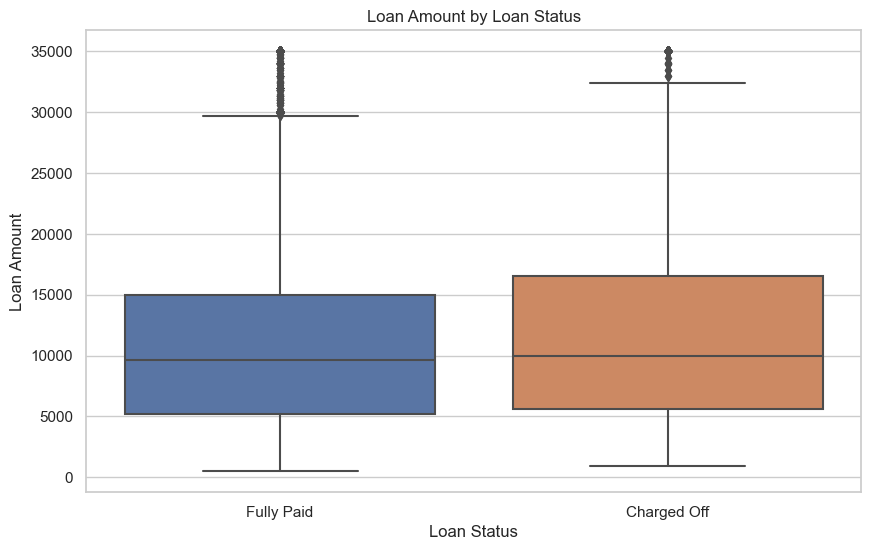

<Figure size 640x480 with 0 Axes>

In [63]:
# Bivariate Analysis
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='loan_amnt', data=df_filtered)
plt.title('Loan Amount by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Loan Amount')
plt.show()
# Save the plot
plt.savefig('loan_amount_status.png')

> examine relation ship between loan grade and loan default

<Figure size 1000x600 with 0 Axes>

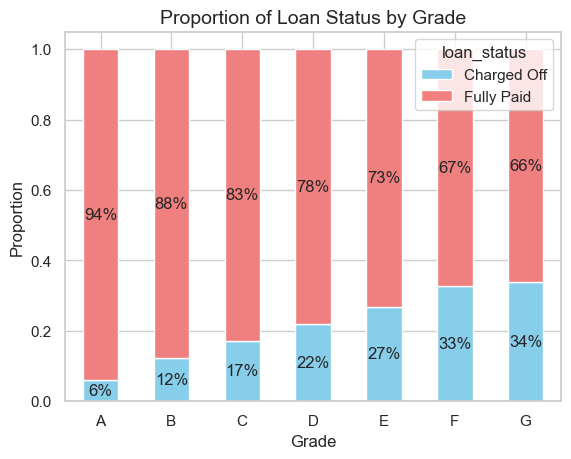

<Figure size 640x480 with 0 Axes>

In [17]:
# Aggregate data by `grade` and `loan_status`, counting occurrences
agg_df_grade = df_filtered.groupby(['grade', 'loan_status']).size().reset_index(name='counts')

# Pivot the table to have `grade` as index and `loan_status` as columns
pivot_df_grade = agg_df_grade.pivot(index='grade', columns='loan_status', values='counts')

# Calculate proportions of each loan status within each grade
pivot_df_prop_grade = pivot_df_grade.div(pivot_df.sum(axis=1), axis=0)

# Create a stacked bar chart using seaborn
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
ax = pivot_df_prop_grade.plot(kind='bar', stacked=True, color=['skyblue', 'lightcoral'])

# Add labels and title
plt.xlabel('Grade', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.title('Proportion of Loan Status by Grade', fontsize=14)
plt.xticks(rotation=0)

# Add annotations to display percentages
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:  # Only annotate bars with non-zero height
        ax.annotate(f'{height:.0%}', (x + width / 2, y + height / 2), ha='center', va='center')

# Show the plot
plt.show()
# Save the plot
plt.savefig('loan_grade_status.png')

In [19]:
# Filter out 'NONE' and 'OTHER' from `home_ownership`
df_filtered_with_home_ownership = df[~df['home_ownership'].isin(['NONE', 'OTHER'])].copy()

# Aggregate data by `home_ownership` and `loan_status`, counting occurrences
agg_df_home = df_filtered_with_home_ownership.groupby(['home_ownership', 'loan_status']).size().reset_index(name='counts')

# Pivot the table to have `home_ownership` as index and `loan_status` as columns
pivot_df_home = agg_df_home.pivot(index='home_ownership', columns='loan_status', values='counts')

# Calculate proportions of each loan status within each `home_ownership` category
pivot_df_prop_home = pivot_df_home.div(pivot_df_home.sum(axis=1), axis=0)

<Figure size 1000x600 with 0 Axes>

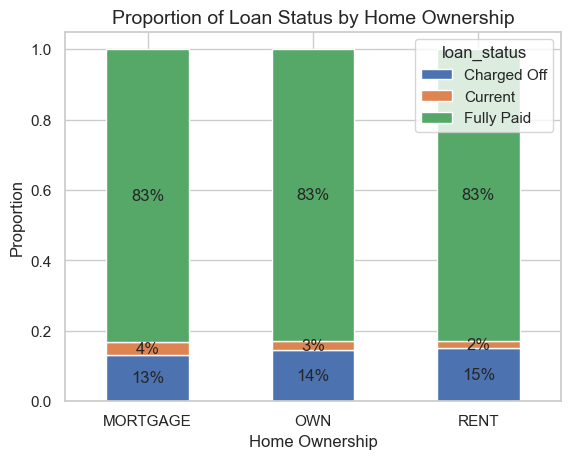

<Figure size 640x480 with 0 Axes>

In [20]:
# Create a stacked bar chart using seaborn with `home_ownership` on the x-axis and proportions on the y-axis
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
ax = pivot_df_prop_home.plot(kind='bar', stacked=True)

# Add labels and title
plt.xlabel('Home Ownership', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.title('Proportion of Loan Status by Home Ownership', fontsize=14)
plt.xticks(rotation=0)

# Add annotations to display percentages
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:  # Only annotate bars with non-zero height
        ax.annotate(f'{height:.0%}', (x + width / 2, y + height / 2), ha='center', va='center')

# Show the plot
plt.show()
# Save the plot
plt.savefig('home_ownership_loan_status.png')

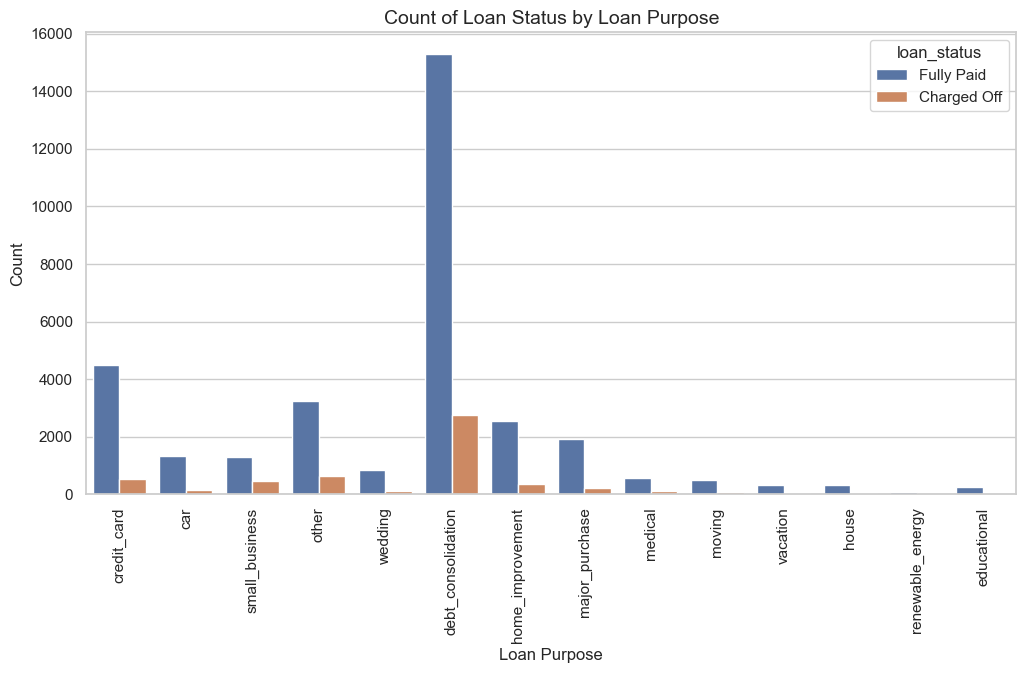

<Figure size 640x480 with 0 Axes>

In [22]:
# Create a count plot using seaborn with `purpose` on the x-axis and hue as `loan_status`
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
sns.set(style="whitegrid")
sns.countplot(x='purpose', hue='loan_status', data=df_filtered)

# Add labels and title
plt.xlabel('Loan Purpose', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Count of Loan Status by Loan Purpose', fontsize=14)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()
# Save the plot
plt.savefig('purpose_loan_status.png')

## Loan Purpose Analysis
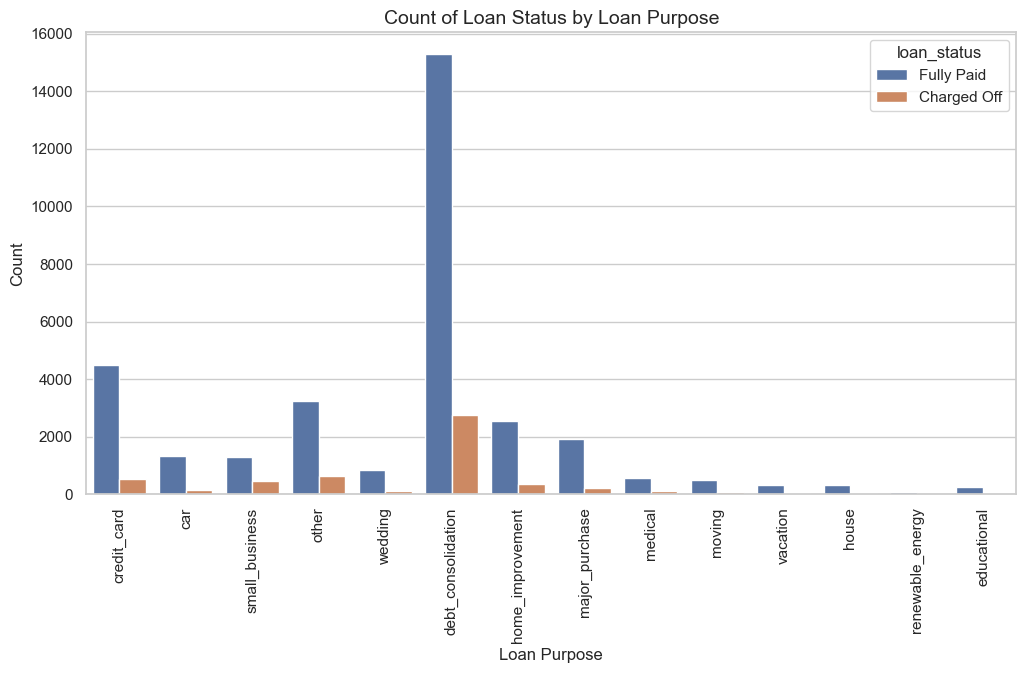
The visualization reveals the relationship between loan purpose and the count of charged-off loans. 'Debt Consolidation' loans have a notably higher count of charged-off loans compared to other purposes. This suggests that Debt consolidation loans are riskier in terms of default compared to loans taken for other purposes.

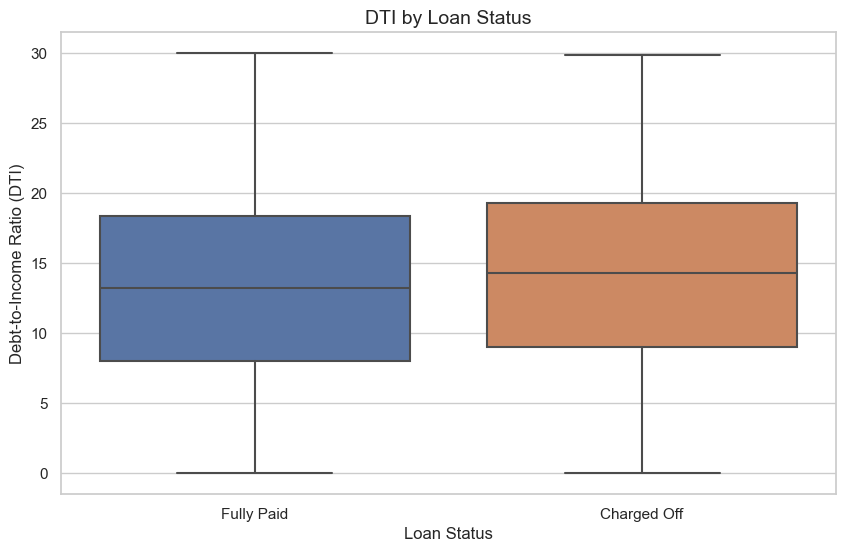

<Figure size 640x480 with 0 Axes>

In [24]:
# Create a box plot using seaborn with `loan_status` on the x-axis and `dti` on the y-axis
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.boxplot(x='loan_status', y='dti', data=df_filtered)

# Add labels and title
plt.xlabel('Loan Status', fontsize=12)
plt.ylabel('Debt-to-Income Ratio (DTI)', fontsize=12)
plt.title('DTI by Loan Status', fontsize=14)

# Show the plot
plt.show()
# Save the plot
plt.savefig('dti_loan_status.png')

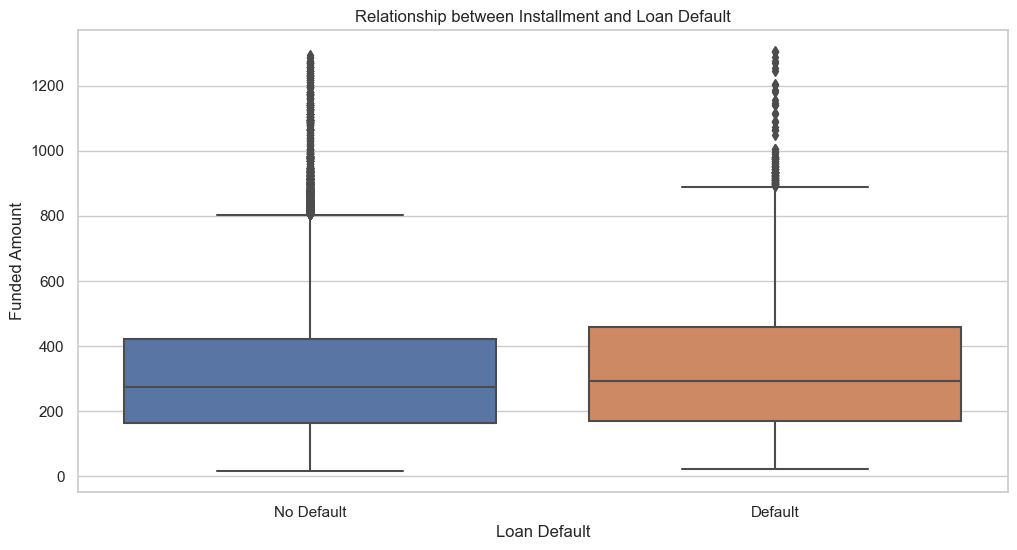

<Figure size 640x480 with 0 Axes>

In [26]:
# Plot the relationship between funded amount and loan default
plt.figure(figsize=(12, 6))
sns.boxplot(x='loan_default', y='installment', data=df_filtered)
plt.title('Relationship between Installment and Loan Default')
plt.xlabel('Loan Default')
plt.ylabel('Funded Amount')
plt.xticks(ticks=[0, 1], labels=['No Default', 'Default'])
plt.show()
# Save the plot
plt.savefig('installment_loan_status.png')

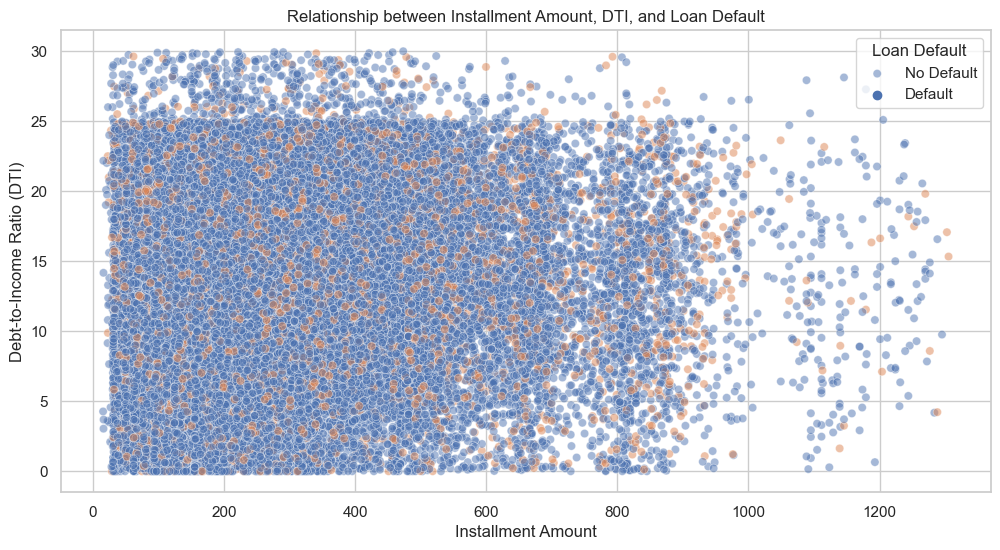

<Figure size 640x480 with 0 Axes>

In [27]:
# Plot the relationship between installment amount, DTI, and loan default using a scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(x='installment', y='dti', hue='loan_default', data=df_filtered, alpha=0.5)
plt.title('Relationship between Installment Amount, DTI, and Loan Default')
plt.xlabel('Installment Amount')
plt.ylabel('Debt-to-Income Ratio (DTI)')
plt.legend(title='Loan Default', labels=['No Default', 'Default'])
plt.show()

# Save the plot
plt.savefig('dti_ins_loan_status.png')